# Notebook to accompany "A guide to LIGO-Virgo detector noise"

This notebook is intended to reproduce some plots from the paper "A guide to LIGO-Virgo detector noise and extratraction of transient gravitational-wave signals" (arXiv:1908.11170)

The notebook was tested using python 3.7.  In particular, we used the conda enviornment "ligo-py37", described here:
https://docs.ligo.org/lscsoft/conda/environments/#available-environments

This notebook is intended as an educational demonstration to reproduce some of the figures in the paper ["A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals"](https://inspirehep.net/record/1751757) , 
and may differ from the [C library code](https://doi.org/10.5281/zenodo.3380539) that has been used to produce the figures of the paper. Additional open source software libraries used by the LIGO Scientific Collaboration and Virgo Collaboration to produce published results are also available. See, for example, the list of open source libraries at https://www.gw-openscience.org/software/

## Download data files

Download each of the following files into the directory where you would like to run the notebook.  Most of these data files are described at: 

https://www.gw-openscience.org/events/GW150914/

In [1]:
# -- Helper python module to open LIGO data files
! wget -q -N https://www.gw-openscience.org/static/sample_code/readligo.py 
    
# -- Download 4096 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126257414-4096.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126257414-4096.hdf5
    
# -- Download 32 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126259446-32.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126259446-32.hdf5
    
# -- Download waveform template
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig2-unfiltered-waveform-H.txt
    
# -- Download data from Figure 1 of GW150914 detection paper
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-L.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-L.txt

## Import needed python modules

Most of these are common python packages, and can be easily installed using pip.  

The notebook was tested using python 3.7.  In particular, we used the conda enviornment "ligo-py37", described here:
https://docs.ligo.org/lscsoft/conda/environments/#available-environments

In [2]:
# Standard python numerical analysis imports:
import numpy as np
import scipy
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import h5py
import json

# plotting items
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# -- Set some parameters that control how plots are displayed
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['lines.linewidth'] = .75

# LIGO-specific readligo.py 
# Download from https://www.gw-openscience.org/static/sample_code/readligo.py
import readligo as rl

## Calculate the noise power spectral density (PSD)

In [3]:
# these 4096 second files are useful for computing more accurate psds
large_data_filenames = {'GW150914': 'LOSC_4_V2-1126257414-4096.hdf5'}
fn_H1 = 'H-H1_' + large_data_filenames['GW150914']
fn_L1 = 'L-L1_' + large_data_filenames['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: H-H1_LOSC_4_V2-1126257414-4096.hdf5


In [4]:
def get_full_psds(eventnames, large_data_filenames,
                  make_plots=False, plot_others=False):
    """Obtains full 1024 second psds for all the events specified. Uses the Welch
    average technique, along with other less accurate techniques if
    specified. Can also plot the psd obtained.
    
    Args: 
        eventnames (list): list of events to get psds for
        large_datafilenames (dict): dictionary whose keys are the eventnames 
            and whose values are the filenames of the large amounts of strain
            data used, without the added 'H-<det>_'
        make_plots (bool, optional): if set to True, plot psd data
        plot_others (bool, optional): if set to True, also obtain psd data 
            without averaging as well as with no window
    
    Returns:
        dict: A dictionary containing psds for each detector for each event 
            specified in eventnames.
    """

    large_data_psds = {}
    for eventname in eventnames:
        large_data_psds[eventname] = {'H1': [], 'L1': []}

        # get filename
        fn_H1 = 'H-H1_' + large_data_filenames[eventname]
        fn_L1 = 'L-L1_' + large_data_filenames[eventname]

        # get strain data
        strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
        strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

        # both H1 and L1 will have the same time vector, so:
        time = time_H1

        indxt_around = np.where((time >= time_center - 512) & (
            time < time_center + 512))

        # number of sample for the fast fourier transform:
        NFFT = int( 4 * fs )           # Use 4 seconds of data for each fourier transform
        NOVL = int( 1 * NFFT / 2 )     # The number of points of overlap between segments used in Welch averaging
        psd_window = scipy.signal.tukey(NFFT, alpha=1./4)

        Pxx_H1, freqs = mlab.psd(strain_H1[indxt_around], Fs=fs, NFFT=NFFT,
                                 window=psd_window, noverlap=NOVL)
        Pxx_L1, freqs= mlab.psd(strain_L1[indxt_around], Fs=fs, NFFT=NFFT, 
                                window=psd_window, noverlap=NOVL)
        

        if (plot_others):
            # smaller window if we're not doing Welch's method
            short_indxt_away = np.where((time >= time_center - 2) & (
                time < time_center + 2))
            # psd using a tukey window but no welch averaging
            tukey_Pxx_H1, tukey_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, window=psd_window)
            # psd with no window, no averaging
            nowin_Pxx_H1, nowin_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, 
                window=mlab.window_none)

        # We will use interpolations of the PSDs computed above for whitening:
        psd_H1 = interp1d(freqs, Pxx_H1)
        psd_L1 = interp1d(freqs, Pxx_L1)

        large_data_psds[eventname]['H1'] = psd_H1
        large_data_psds[eventname]['L1'] = psd_L1

        if make_plots:
            plt.figure(figsize=(8, 5))
            # scale x and y axes
            plt.xscale('log', base=2)
            plt.yscale('log', base=10)

            # plot nowindow, tukey, welch together 
            plt.plot(nowin_freqs, nowin_Pxx_H1,'purple',label= 'No Window',
                     alpha=.8, linewidth=.5)
            plt.plot(tukey_freqs, tukey_Pxx_H1 ,'green',label='Tukey Window',
                     alpha=.8, linewidth=.5)
            plt.plot(freqs, Pxx_H1,'black',label='Welch Average', alpha=.8,
                     linewidth=.5)

            # plot 1/f^2
            # give it the right starting scale to fit with the rest of the plots
            # don't include zero frequency
            inverse_square = np.array(list(map(lambda f: 1 / (f**2), 
                                    nowin_freqs[1:])))
            # inverse starts at 1 to take out 1/0
            scale_index = 500 # chosen by eye to fit the plot
            scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
            plt.plot(nowin_freqs[1:], inverse_square * scale,'red',
                     label= r'$1 / f^2$', alpha=.8, linewidth=1)

            plt.axis([20, 512, 1e-48, 1e-41])
            plt.ylabel('Sn(t)')
            plt.xlabel('Freq (Hz)')
            plt.legend(loc='upper center')
            plt.title('LIGO PSD data near ' + eventname + ' at H1')
            plt.show()

    return large_data_psds

/Users/jkanner/miniconda2/envs/ligo-py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


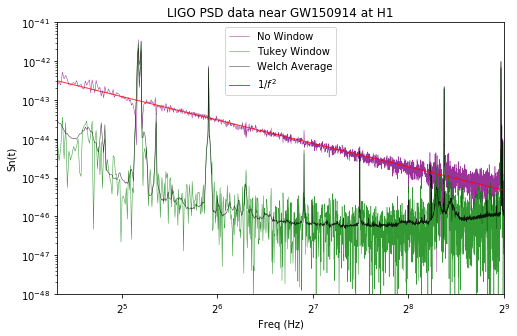

In [5]:
eventnames = ['GW150914']
large_data_psds = get_full_psds(eventnames, large_data_filenames,
                                make_plots=True, plot_others=True)

Note that inadequate windowing of these strongly colored data produces a psd that 
is entirely dominated by "spectral leakage",
https://en.wikipedia.org/wiki/Spectral_leakage,
and inadequate averaging leads to noise fluctuations that contaminate the estimated PSD.


## Whiten and Bandpass Functions

Now we'll create some helper functions to whiten and bandpass data within a
given frequency band. These allow us to better see some signal in our data:

In [6]:
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(strain, fband, fs):
    """Bandpasses strain data using a butterworth filter.
    
    Args:
        strain (ndarray): strain data to bandpass
        fband (ndarray): low and high-pass filter values to use
        fs (float): sample rate of data
    
    Returns:
        ndarray: array of bandpassed strain data
    """
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_bp = filtfilt(bb, ab, strain) / normalization
    return strain_bp

## Plot strain data that has been windowed, bandpassed, and whitened

In [7]:
def plot_strain_data(fn_H1, fn_L1, eventname):
    """Plots windowed, whitened, and bandpassed strain vs time near a given
    event.

    Args:
        fn_H1: name of H1 data file
        fn_L1: name of L1 data file
        eventname: name of the event
    """
    
    fband = [35.0, 350.0]

    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

    # both H1 and L1 will have the same time vector
    time = time_H1
    
    # create our 4 second data window
    window_len = 4*fs
    dwindow = scipy.signal.tukey(window_len, alpha=1./4)

    # plot original strain data
    # only care about 4s around event
    plt.figure(figsize=(8, 8))
    plt.subplot(4, 1, 1)
    indxt = np.where((time >= time_center - 2) & (time < time_center + 2))
    plt.xlim([-2, 2])
    plt.plot(time[indxt] - time_center, strain_H1[indxt], 'blue', 
             label='Hanford Data', linewidth=.5)
    plt.legend()

    # plot windowed data
    plt.subplot(4, 1, 2)
    strain_windowed = dwindow * strain_H1[indxt]
    plt.xlim([-2, 2])
    plt.plot(time[indxt] - time_center, strain_windowed, 'green', 
             label='Windowed Data', linewidth=.5)
    plt.legend()
    
    
    # plot whitened data
    plt.subplot(4, 1, 3)
    strain_whitened = whiten(strain_windowed, 
                             large_data_psds[eventname]['H1'], dt)
    plt.plot(time[indxt] - time_center, strain_whitened, 'red', 
             label='Whitened Data', linewidth=.5)
    plt.legend()

    # plot bandpassed data
    plt.subplot(4, 1, 4)
    strain_bp = bandpass(strain_whitened, fband, fs)
    plt.xlim([-2, 2])
    plt.plot(time[indxt] - time_center, strain_bp, 'black', 
             label='Bandpassed Data', linewidth=.5)

    plt.legend()
    plt.yticks([-6, -3, 0, 3, 6, 9])
    plt.tight_layout()
    plt.xlim([-2, 2])
    plt.ylim([-8, 8])
    plt.show()

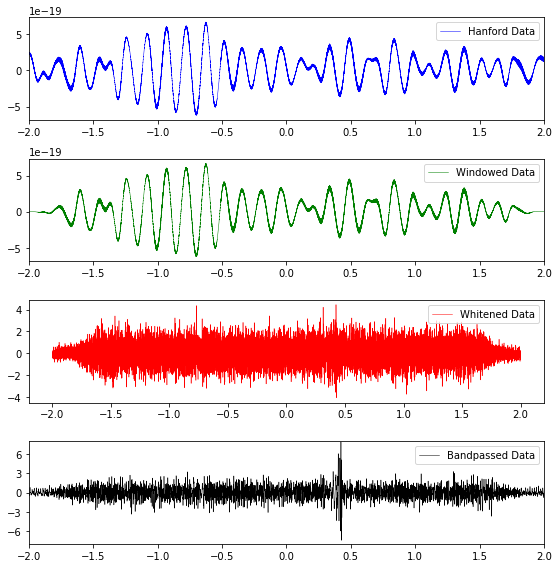

In [8]:
plot_strain_data(fn_H1, fn_L1, 'GW150914')

## Method for getting whitened/banspassed event data

In [9]:
def get_strain_whitenbp_data(fn_H1, fn_L1, fband, eventname):
    
    # get strain data
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

    # both H1 and L1 will have the same time vector, so:
    time = time_H1

    # whiten, bandpass the data
    strain_H1_whiten = whiten(strain_H1, large_data_psds[eventname]['H1'], dt)
    strain_L1_whiten = whiten(strain_L1, large_data_psds[eventname]['L1'], dt)

    strain_H1_whitenbp = bandpass(strain_H1_whiten, fband, fs)
    strain_L1_whitenbp = bandpass(strain_L1_whiten, fband, fs)
    
    # return results as a dictionary for more intuitive access
    total_data = {'H1': {'strain': strain_H1, 'strain_whiten': strain_H1_whiten,
                         'strain_whitenbp': strain_H1_whitenbp}, 'L1': 
                  {'strain': strain_L1, 'strain_whiten': strain_L1_whiten, 
                   'strain_whitenbp': strain_L1_whitenbp}, 'time': time, 'dt': dt}
                   
    return total_data

In [10]:
fn_H1_32 = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
fn_L1_32 = 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
total_GW150914_data = get_strain_whitenbp_data(fn_H1_32, fn_L1_32, [35., 350.], 'GW150914')

In [11]:
def plot_fourier_phases(data, time): 
    """Plots Fourier phases of strain data.

    Args:
        data (ndarray): strain data
        time (ndarray): time corresponding to data.
    """
    # do this both with and without a spectral window
    plt.figure(figsize=(8, 5))
    tukey_window = signal.tukey(data.size, alpha=1./4),
    labels = ['Tukey window', 'No window']
    colors = ['red', 'blue']
    
    # apply each window and find phases of the fft
    for i, dwindow in enumerate([tukey_window, 1]):
        data_fft = np.fft.rfft((data * dwindow).flatten()) * dt
        datafreq = np.fft.rfftfreq(data.size) / dt
        phases = np.angle(data_fft)
        # convert angles to range (0, 2 pi)
        phases = (phases + 2 * np.pi) % (2 * np.pi)
        plt.plot(datafreq, phases, '.', label=labels[i], 
                 color=colors[i], markersize=1)
        
    plt.xlim([30, 400])
    plt.ylim([0, 6])
    plt.xlabel('f(Hz)')
    plt.ylabel('Phase')
    plt.legend(loc='upper right', fontsize=7)

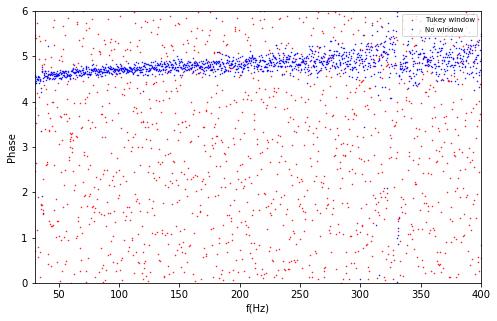

In [12]:
indxt = np.where((total_GW150914_data['time'] >= time_center - 2) & (
    total_GW150914_data['time'] < time_center + 2))
plot_fourier_phases(total_GW150914_data['H1']['strain'][indxt],
                    total_GW150914_data['time'][indxt])

Note that the fourier phases for properly windowed data (random noise) are random between [0, 2*pi];
by contrast, un-windowed data produce strongly correlated fourier phases that are artifacts of the abrupt beginning and end of the data stretch.

## Define matched filter method to search for a waveform in data

In [13]:
def matched_filter(template, data, time, data_psd, fs):
    """Runs the matched filter calculation given a specific real template, strain
    data, time, psd, and sample rate. Finds the offset and phase to maximize
    SNR, as well as effective distance and horizon

    Args:
        template (ndarray): real part of initial template corresponding to event
        data (ndarray): strain data near event
        time (ndarray): time near event
        data_psd (interpolating function): psd of strain data around event
        fs (float): sample rate of data
    
    Returns:
        float: maximum SNR value obtained
        float: time of maximum SNR value
        float: effective distance found
        float: horizon found
        float: template phase which maximizes SNR
        float: template offset which maximizes SNR
    """

    # get the fourier frequencies of data for when we fft (for dividing by psd)
    datafreq = np.fft.fftfreq(template.size)*fs
    df = np.abs(datafreq[1] - datafreq[0])
    # for taking the fft of our template and data
    dwindow = signal.tukey(template.size, alpha=1./4)
    # compute the template and data ffts.
    template_fft = np.fft.fft(template*dwindow) / fs
    data_fft = np.fft.fft(data*dwindow) / fs

    # use the larger psd of the data calculated earlier for a better calculation
    power_vec = list(map(data_psd, np.abs(datafreq)))

    # -- Zero out negative frequencies
    negindx = np.where(datafreq<0)
    data_fft[negindx] = 0

    # -- Calculate the matched filter output in the time domain: Multiply
    # the Fourier Space template and data, and divide by the noise power in
    # each frequency bin.  Taking the Inverse Fourier Transform (IFFT) of
    # the filter output puts it back in the time domain, so the result will
    # be plotted as a function of time off-set between the template and the
    # data:
    optimal = data_fft * template_fft.conjugate() / power_vec  
    optimal_time = 4 * np.fft.ifft(optimal) * fs

    # -- Normalize the matched filter output: Normalize the matched filter
    # output so that we expect an average value of 1 at times of just noise.  Then,
    # the peak of the matched filter output will tell us the
    # signal-to-noise ratio (SNR) of the signal.
    sigmasq = 2 * (template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at
    # the end of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the effective distance
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = -np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    return SNRmax, timemax, d_eff, horizon, phase, offset

## Define helper function to apply time and phase shifts

In [14]:
def get_shifted_data(template_p, strain, time, strain_whiten,
                     strain_whitenbp, fband, filter_data, data_psd):
    """Obtains data shifts of templates and residual data after having found the
    best fit phase and offsets for the template.
    
    Args:
        template_p (ndarray): real (plus-polarization) part of template
        strain (ndarray): strain data
        time (ndarray): time
        strain_whiten (ndarray): whitened strain data
        strain_whitenbp (ndarray): whitened and bandpassed strain data
        fband (list): low and high pass filters for the template bandpass 
        filter_data (dict): dictionary containing phase, offset, d_eff values 
            for given matched filter calculation
        data_psd (interpolating function): function which outputs a power value
            for a given data frequency 

    Returns:
        ndarray: whitened, bandpassed, phaseshifted and offset template
        ndarray: phaseshifted and offset residual data
        ndarray: whitened, phaseshifted and offset residual data
        ndarray: whitened, bandpassed, phaseshifted and offset residual data
    """
    d_eff = filter_data['d_eff']
    phase = filter_data['phase']
    offset = filter_data['offset']

    # apply time and phase shift to template- we'll do this in the freq domain
    Nt = len(template_p)
    freqs = np.fft.rfftfreq(Nt, dt)
    # apply the fft, also scaling initial amplitude
    hf = np.fft.rfft(template_p / d_eff)
    # apply phase shift, time offset
    hf = hf * np.exp(-1.j * 2 * np.pi * (offset * dt) * freqs - 1.j * phase)
    # transform back
    template_shifted = np.real(np.fft.irfft(hf, n=Nt))

    # whiten and bandpass template_p for plotting- also applying phase shift,
    # amplitude scale
    template_whitened = whiten(template_p / d_eff, data_psd, dt,
                               phase_shift=phase, time_shift=(offset * dt))
    template_match = bandpass(template_whitened, fband, 1. / dt)

    # save the residual for later
    resid_data_whiten= strain_whiten - template_whitened
    resid_data_whitenbp = strain_whitenbp - template_match

    # save the nonbandpassed, nonwhitened residual as well
    resid_data = strain - template_shifted
    return template_match, resid_data, resid_data_whiten, resid_data_whitenbp

## Wrapper method to calculate and plot the matched filter results for both H1 and L1

In [15]:
# calculate matched filter between actual template
def calculate_matched_filter(template_p, eventname, t_amount,
                             total_data, make_plots=False,
                             print_vals=True):
    """Calculates the best-fit template phase, offset, d_eff, horizon, and SNRmax
    values for both detectors on a given stretch of data given the desires
    template. Also can plot template shifts/residual data and print the
    parameters found.
    
    Args:
        template_p (ndarray): plus polarization of template
        event (dict): subdictionary of BBH-events containing event parameters
        t_amount (float): amount of time (s) around event to calcualate the
            matched filter
        total_data (dict): dict containing original and whitenbp strain data
        make_plots (bool, optional): if True, plot template shifts, 
            whitened data, and residuals for each det.
        print_vals (bool, optional): if True, output params found
    
    Returns:
        dict: dictionary of parameters found and residual data for each detector
    """
    
    # these specific values are defined in the paper
    fband = [35.0, 350.0]
    
    time = total_data['time']

    # these dictionaries will be returned with our matched filter data and
    # residuals
    filter_data = {'H1': {}, 'L1': {}}
    
    # amount of data we want to calculate matched filter SNR over- up to 32s
    data_time_window = time[len(time) - 1] - time[0] - (32 - t_amount)

    time_filter_window = np.where((time <= time_center + data_time_window * .5) &
                                  (time >= time_center - data_time_window * .5))
    time_filtered = time[time_filter_window]
    template_p = template_p[time_filter_window]

    # define the template using only the plus polarization
    template = template_p

    # construct subplot now before looping
    if make_plots:
        fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

    # loop over the detectors
    dets = ['H1', 'L1']
    for i, det in enumerate(dets):
        strain = total_data[det]['strain'][time_filter_window]
        strain_whiten = total_data[det]['strain_whiten'][time_filter_window]
        strain_whitenbp = total_data[det]['strain_whitenbp'][time_filter_window]
        data_psd = large_data_psds[eventname][det]

        # save the time for later
        filter_data[det]['time'] = time_filtered

        # find the best fit phase, offset, d_eff, horizon
        SNRmax, timemax, d_eff, horizon, phase, offset = matched_filter(
            template, strain, time_filtered, data_psd, fs)

        # save these vals for later
        filter_data[det]['SNR'] = SNRmax
        filter_data[det]['d_eff'] = d_eff
        filter_data[det]['phase'] = phase
        filter_data[det]['offset'] = offset

        if (print_vals):
            print("The phase offset is {0:.3f} radians".format(phase))
            print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, ' 
                  .format(det, timemax, SNRmax))

        # get residuals and whitened data/template
        template_wbp, resid_data, resid_data_w, resid_data_wbp = get_shifted_data(
            template_p, strain, time_filtered, strain_whiten,
            strain_whitenbp, fband, filter_data[det], data_psd)
            
        filter_data[det]['residual'] = resid_data
        filter_data[det]['residual_whiten'] = resid_data_w
        filter_data[det]['residual_whitenbp'] = resid_data_wbp

        if make_plots:
            # plot whitened, phase and time shifted templates, data, residuals
            ax = axes[i]
            ax.plot(time_filtered - time_center, strain_whitenbp, 'b',
                    label=det + ' data')
            ax.plot(time_filtered - time_center, template_wbp, 'r',
                    label=det + 'model')
            ax.set_ylim([-8, 8])
            ax.legend(loc='upper left')
            
            ax = axes[i + 2]
            ax.plot(time_filtered - time_center, resid_data_wbp, 'k', 
                    label=det+' residual')
            ax.set_ylim([-4, 4])
            ax.legend(loc='upper left')
            plt.xlim([.25, .46])
            plt.xlabel('Time since {0:.4f}'.format(time_center))
            
    return filter_data

## Read in, taper, and zero-pad the waveform template

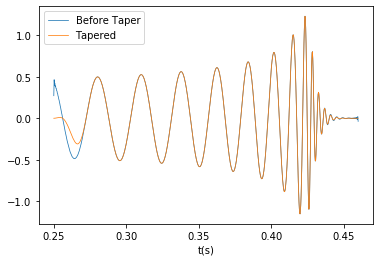

In [16]:
fig_template = np.genfromtxt('fig2-unfiltered-waveform-H.txt')

# Remove the time vector
fig_template = fig_template[:, 1]

# Downsample this data to 4096 Hz
fig_template = scipy.signal.resample(fig_template, int(len(fig_template)/4) )

# apply a Tukey window to taper the ends of the template
taper_window = signal.tukey(len(fig_template), alpha=.25)
fig_template_tapered = fig_template * taper_window

# -- Plot template before and after tapering
template_time = np.arange(0.25, 0.25+len(fig_template_tapered)*dt,dt)
plt.plot(template_time,fig_template, label='Before Taper')
plt.plot(template_time, fig_template_tapered, label='Tapered')
plt.xlabel('t(s)')
plt.legend()

# Now we need to pad this with 0s to make it the same amount of time as the data
halfdatalen = int(16*fs)
begin_add = halfdatalen - len(fig_template_tapered)

# add last 2048 seconds
fig_template_tapered = np.append(fig_template_tapered, (halfdatalen * [0]))
# add beginning- almost 2048 seconds
fig_template_tapered = np.append((int(begin_add) * [0]), fig_template_tapered)


The effect of the tapering Tukey window is visible at the beginning of the template.  Tapering forces the template to have zero values at the ends, in order to avoid artefacts due to discontinuities when taking an FFT.

## Use the methods defined above to calculate the matched filter result for GW150914

Note, the results of matched filtering are sensitive to small changes in PSD estimation, and so running similar codes may not give identical results.   The calculated SNR is particularly sensitive, and differences of a few percent between different implementations are typically expected.

The phase offset is -0.285 radians
For detector H1, maximum at 1126259462.4602 with SNR = 19.0, 
The phase offset is 2.635 radians
For detector L1, maximum at 1126259462.4531 with SNR = 13.4, 


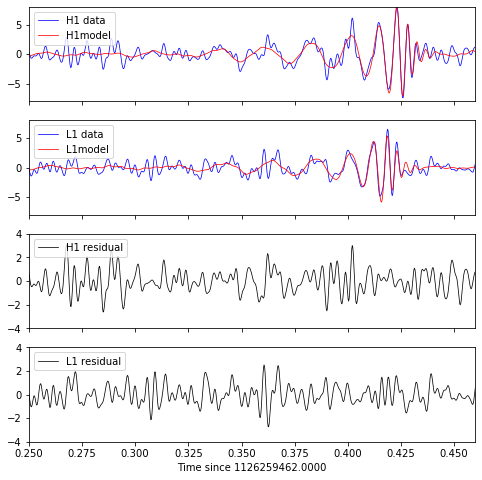

In [17]:
matched_filter_data = calculate_matched_filter(
    fig_template_tapered, 'GW150914', 4, total_GW150914_data, make_plots=True)

## Report results of matched filter

In [18]:
print('Alpha values:')
print(list(map(lambda det: {det: 1 / matched_filter_data[det]['d_eff']},
          matched_filter_data.keys())))
print('Phase difference between H1 and L1:')
print("{0:.2f} radians".format(matched_filter_data['H1']['phase'] - matched_filter_data['L1']['phase']))
# have to multiply the offset by dt
#dt = matched_filter_data['H1']['time'][1] - matched_filter_data['H1']['time'][0] 
print('Time offset between H1 and L1:')
print("{0:.6f} seconds".format((matched_filter_data['H1']['offset'] - matched_filter_data['L1']['offset'])*dt))
print('Ratio of SNRs (H1_SNR/L1_SNR):') 
print(matched_filter_data['H1']['SNR'] / matched_filter_data['L1']['SNR'])

Alpha values:
[{'H1': 8.954634920353649e-22}, {'L1': 7.216096610966259e-22}]
Phase difference between H1 and L1:
-2.92 radians
Time offset between H1 and L1:
0.007080 seconds
Ratio of SNRs (H1_SNR/L1_SNR):
1.4214341186505586


## Plot template with best fit phase, time, and amplitude

In [19]:
def plot_shifted_templates(matched_filter_data, total_data, template_p,
                           t_amount):
    """Plots phaseshifted and offset templates given original shifts and offsets
    found from the matched filter.

    Args:
        event (dict): subdictionary containing event parameters
        matched_filter_data (dict): dictionary containing matched filter phases,
            offsets, residuals
        total_data (dict): dictionary containing original and whitenbp data
        template_p (ndarray): plus polarization of template
        t_amount (float): amount of time to plot templates over around event
    """
    # get our previous time data around event
    time = total_data['time']

    # filter data around event depending on how many seconds we want to plot
    time_filter = np.where((time >= time_center - t_amount) & 
                           (time <= time_center + t_amount))
    time = time[time_filter]
    template_p = template_p[time_filter]
    dwindow = signal.tukey(template_p.size, alpha=1./4)

    # set up plot axes and limits
    fig, axes = plt.subplots(3, 1, figsize=(9, 5), sharex=True)
    axes[0].set_ylabel('h(t)')
    # plot original (windowed) template with same offset as first
    axes[0].plot(time - time_center + matched_filter_data['H1']['offset'] / (
        1.*fs), template_p * dwindow, 'black', label='Reference Template')
    axes[0].legend(frameon=True)
    plt.xlabel('t(s)')
    plt.xlim([.2, .5])
    
    # keys are the detectors
    # plot each template shifted from detector
    for i, det in enumerate(matched_filter_data.keys()):
        phase = matched_filter_data[det]['phase']
        offset = matched_filter_data[det]['offset']
        alpha = 1 / matched_filter_data[det]['d_eff']

        # apply amp, time and phase shift to template- do this in the freq domain
        Nt = len(template_p)
        freqs = np.fft.rfftfreq(Nt, dt)
        # apply the fft on windowed data, also scaling initial amplitude
        hf = np.fft.rfft(template_p * dwindow) * alpha
        # apply phase shift, time offset
        hf = hf * np.exp(-1.j * 2 * np.pi * (offset * dt) * freqs - 1.j * phase)
        # transform back
        template_shifted = np.real(np.fft.irfft(hf, n=Nt))

        axes[i + 1].plot(time - time_center, template_shifted, label=det)
        axes[i + 1].legend(frameon=True)
        axes[i + 1].set_ylabel('h(t)')

    plt.show()

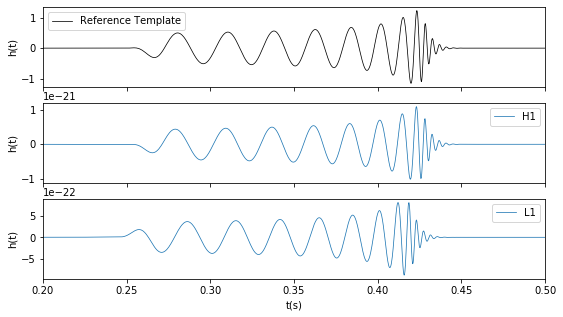

In [20]:
plot_shifted_templates(matched_filter_data,
                       total_GW150914_data, fig_template_tapered, 1)

## Check for correlations in the residual detector noise

In [21]:
def cross_correlate(d1, d2):
    """finds the cross-correlation between two arrays d1 and d2"""
    return plt.xcorr(d1, d2, maxlags=len(d1) - 1)

def get_correlation(H1_data, L1_data, time, t_min, t_max):
    """obtains the cross correlation between the H1 and L1 strain data arrays,
    limited to times in between t_min and t_max of the corresponding time array.

    Args:
        H1_data (ndarray): H1 strain data
        L1_data (ndarray): L1 strain data
        time (ndarray): Time corresponding to both H1 and L1 data.
        t_min (float): Minimum time for data cross-correlation
        t_max (float): Maximum time for data cross-correlation
    
    Returns:
        ndarray: cross-correlation values obtained
        ndarray: time shifts for the given correlation values
    """
    # we're only doing this between t_min and t_max
    time_int = np.where((time >= t_min) & (time <= t_max))
    H1_int = H1_data[time_int]
    L1_int = L1_data[time_int]

    correlation = cross_correlate(H1_int, L1_int)
    lags = correlation[0]
    corr = correlation[1]
    # here we have one correlation value for each possible lag, total amount is
    # 2 * len(t_int)
    interval_len = (t_max - t_min)
    time_diffs = np.linspace(-1 * interval_len, interval_len, len(corr))
    return corr, time_diffs
    
def run_cross_corrs(resid_H1, resid_L1, resid_time, orig_H1, orig_L1,
                    orig_time, t, s=.25, e=.46):
    """Runs 4 different cross correlations for the H1, L1 residual data and time,
    the H1, L1 original strain data and time: Full interval, first half, last
    half, and .39-43s.
    
    Args:
        resid_H1 (ndarray): residual H1 data from event
        resid_L1 (ndarray): residual L1 data from event
        resid_time (ndarray): time corresponding to resid data
        orig_H1 (ndarray): original H1 strain data from event
        orig_L1 (ndarray): original L1 strain data from event
        orig_time (ndarray): time corresponding to orig data
        t (float): starting time of time interval
        s (float): starting time of full correlation interval
        e (float): ending time of full correlation interval
    
    Returns:
        dict: dictionary containing residual correlation values, whose keys 
            are the various time intervals
        dict: dictionary containing original strain correlation values, whose
            keys are the various time intervals
    """
    # define 4 different intervals for cross correlation
    intervals = {'All 0.2s': (t + s, t + e), 'Last half': (t + s + .1, t + e), 
                'First half': (t + s, t + s + .1), '0.39s-0.43s': (t + .39, t + .43)}

    resid_correlation_vals = {}
    original_correlation_vals = {}
    # go through and calculate for each interval
    for key in intervals.keys():
        interval = intervals[key]
        resid_corr = get_correlation(resid_H1, resid_L1, resid_time,
                                     interval[0], interval[1])
        orig_corr = get_correlation(orig_H1, orig_L1, orig_time, interval[0],
                                    interval[1])
        resid_correlation_vals[key] = resid_corr
        original_correlation_vals[key] = orig_corr
        
    return resid_correlation_vals, original_correlation_vals

In [22]:
resid_H1_data = matched_filter_data['H1']['residual_whitenbp']
resid_L1_data = matched_filter_data['L1']['residual_whitenbp']
resid_time = matched_filter_data['L1']['time']
orig_H1_data = total_GW150914_data['H1']['strain_whitenbp']
orig_L1_data = total_GW150914_data['L1']['strain_whitenbp']
orig_time = total_GW150914_data['time']

resid_correlation_vals, original_correlation_vals = run_cross_corrs(
    resid_H1_data, resid_L1_data, resid_time, orig_H1_data, orig_L1_data,
    orig_time, 1126259462)
# don't want to output plot here; matplotlib plots a plot with correlations 
# but we'll make our own
plt.close()

In [23]:
fig1_data = {'H1': {}, 'L1': {}}
for det in fig1_data.keys():
    for dtype in ['residual', 'observed']: 
        data = np.genfromtxt('fig1-%s-%s.txt'%(dtype, det[0]))
        fig1_data[det][dtype] = {} 
        # split up strain and time
        fig1_data[det][dtype]['time'] = data[:, 0]
        fig1_data[det][dtype]['strain'] = data[:, 1]

In [24]:
time = fig1_data['H1']['residual']['time']
time_observed = fig1_data['H1']['observed']['time']
resid_H1_data = fig1_data['H1']['residual']['strain']
resid_L1_data = fig1_data['L1']['residual']['strain']
observed_H1_data = fig1_data['H1']['observed']['strain']
observed_L1_data = fig1_data['L1']['observed']['strain']

fig_resid_correlation_vals, fig_observed_correlation_vals = run_cross_corrs(
    resid_H1_data, resid_L1_data, time, observed_H1_data,
    observed_L1_data, time_observed, 0)
plt.close()

In [25]:
def plot_correlation_vals_axis(correlation_vals, ax):
    """Plots correlations values obtained on a given axis object."""
    colors = {'First half': 'black', 'Last half': 'red', 'All 0.2s': 'blue',
              '0.39s-0.43s': 'green'}
    for key in correlation_vals.keys():
        corr = correlation_vals[key]
        # plot in ms instead of s
        ax.plot(corr[1] * 1000, corr[0], colors[key], label=key)
        
    yVals = np.linspace(-1, 1, 1000)
    ax.plot([7] * 1000, yVals, '--', color='gray', linewidth=.5)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-1, 1)
    ax.set_ylabel(r'C($\tau$)')
    ax.set_xlabel(r'$\tau$ (ms)')
    ax.legend(loc='upper left')

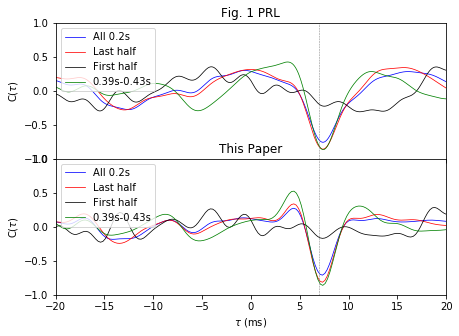

In [26]:
corr_vals = [fig_observed_correlation_vals, original_correlation_vals,
             fig_resid_correlation_vals, resid_correlation_vals]
titles = ['Fig. 1 PRL', 'This Paper']

def plot_subplot(corr_vals, titles):
    """Plots correlation values and titles on the same subplot."""
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
    fig.subplots_adjust(hspace=0)
    for i, ax in enumerate(axes):
        plot_correlation_vals_axis(corr_vals[i], ax) 
        ax.set_title(titles[i])
        
plot_subplot(corr_vals[:2], titles)

Above, calculating cross correlations between the Hanford and Livingston data shows evidence of the signal at a shift of around 7 ms.

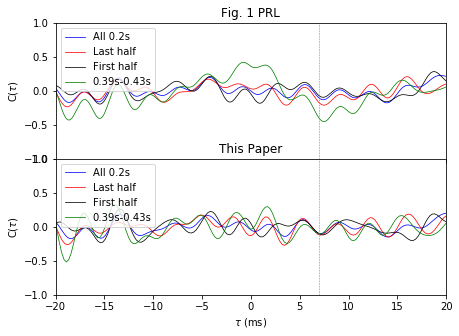

In [27]:
plot_subplot(corr_vals[2:], titles)

As discussed in the associated paper, the residuals displayed in Fig 1 the GW150914 discovery paper, which made use of a less-than-optimal signal subtraction,  show some evidence of correlations (top panel). However, in this notebook, we make use of a maximum likelihood procedure for signal subtraction, which leaves residuals with no evidence of correlations.